# Risk Premia Harvesting - Periodic Deposits with Rebalancing Strategy

## Overview

This notebook implements a dollar-cost averaging strategy with periodic monthly deposits that includes rebalancing at each deposit point. Each month, a fixed dollar amount is invested, but the allocation is dynamically adjusted to bring the portfolio back to target weights of 50/35/15.

**Portfolio Composition:**
- SPY (S&P 500 ETF): 50% target
- TLT (Long-term Treasury ETF): 35% target
- GLD (Gold ETF): 15% target

**Investment Strategy:**
- Monthly deposit: $100.00
- Allocation per deposit: Dynamically calculated to rebalance to 50/35/15
- Investment timing: Start of each month
- Rebalancing: At each deposit (no selling, only via new purchases)
- No separate rebalancing or selling between deposits

**Investment Period:** Approximately 10 years

## Strategy Mechanics

The first deposit is straightforward: $50 to SPY, $35 to TLT, $15 to GLD. 

For subsequent deposits, the allocation is calculated based on current portfolio values:
- Calculate current portfolio value + $100 deposit
- Determine target dollar amounts for each asset (50/35/15 of total)
- Calculate the difference between target and current holdings
- Allocate the $100 deposit proportionally to move closer to target weights

**Example:** If SPY significantly outperforms, its weight might grow to 55%. The next $100 deposit would allocate more to TLT and GLD to rebalance back toward 50/35/15.

## Target Outputs

### Performance Metrics
- Annualized Return
- Annualized Volatility
- Sharpe Ratio
- Maximum Drawdown
- Total Amount Invested
- Final Portfolio Value
- Rebalancing effectiveness metrics

### Visualizations
- Equity curves (total portfolio and individual assets)
- Total capital invested over time
- Portfolio allocation drift over time
- 1-year rolling annualized return
- 1-year rolling annualized volatility
- 1-year rolling Sharpe ratio

## Implementation Steps

### 1. Data Acquisition
Load historical price data for SPY, TLT, and GLD

### 2. Data Preparation
   1. Remove rows with missing data
   2. Ensure all tickers share the same date index
   3. Identify first trading day of each month

### 3. Monthly Investment Logic with Rebalancing
   1. Define monthly deposit amount ($100) and target allocation ratios (50/35/15)
   2. Initialize cumulative shares for each asset
   3. For each month's first trading day:
      - Calculate current portfolio value (cumulative shares × current prices)
      - Calculate total portfolio value after deposit (current value + $100)
      - Calculate target dollar amounts for each asset based on target ratios
      - Calculate current dollar holdings for each asset
      - Determine the gap between target and current holdings
      - Allocate the $100 deposit to minimize allocation gaps:
        * Calculate desired additional amounts for each asset
        * Normalize to ensure total equals $100
      - Convert dollar amounts to shares purchased
      - Update cumulative shares held for each asset

#### Key Implementation Note for Step 3

The rebalancing calculation should work as follows:

For each deposit date:
1. Calculate current value of each asset:
   - current_value_SPY = shares_SPY × price_SPY
   - current_value_TLT = shares_TLT × price_TLT
   - current_value_GLD = shares_GLD × price_GLD
   - total_current = current_value_SPY + current_value_TLT + current_value_GLD

2. Calculate total portfolio value after deposit:
   - total_after_deposit = total_current + 100

3. Calculate target dollar amounts for each asset:
   - target_SPY = 0.50 × total_after_deposit
   - target_TLT = 0.35 × total_after_deposit
   - target_GLD = 0.15 × total_after_deposit

4. Calculate the gap between target and current holdings:
   - gap_SPY = target_SPY - current_value_SPY
   - gap_TLT = target_TLT - current_value_TLT
   - gap_GLD = target_GLD - current_value_GLD

5. Normalize gaps to sum to $100 (proportional rebalancing):
   - total_gap = gap_SPY + gap_TLT + gap_GLD
   - allocation_SPY = (gap_SPY / total_gap) × 100
   - allocation_TLT = (gap_TLT / total_gap) × 100
   - allocation_GLD = (gap_GLD / total_gap) × 100

6. Convert dollar allocations to shares purchased:
   - shares_purchased_SPY = allocation_SPY / price_SPY
   - shares_purchased_TLT = allocation_TLT / price_TLT
   - shares_purchased_GLD = allocation_GLD / price_GLD

7. Update cumulative shares:
   - shares_SPY += shares_purchased_SPY
   - shares_TLT += shares_purchased_TLT
   - shares_GLD += shares_purchased_GLD

### 4. Portfolio Allocation Tracking
   1. Track actual portfolio weights over time
   2. Calculate allocation drift from target weights
   3. Monitor rebalancing effectiveness

### 5. Equity Curve Construction
   1. Calculate daily equity for each asset (cumulative shares × daily price)
   2. Compute total portfolio equity
   3. Track cumulative capital invested over time
   4. Consolidate results into a unified DataFrame

### 6. Returns Calculation
   1. Compute portfolio daily returns
   2. Compute individual asset daily returns

### 7. Performance Statistics
   1. Calculate total capital invested
   2. Calculate annualized return
   3. Calculate annualized volatility
   4. Calculate Sharpe ratio
   5. Calculate maximum drawdown
   6. Calculate average allocation drift from targets

### 8. Static Visualizations
   1. Plot all equity curves on a single chart
   2. Plot cumulative capital invested alongside portfolio value
   3. Plot actual portfolio weights over time vs. target weights

### 9. Rolling Performance Analysis
   1. Generate rolling 1-year annualized return chart
   2. Generate rolling 1-year annualized volatility chart
   3. Generate rolling 1-year Sharpe ratio chart

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Acquisition

spy_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_SPY.csv", index_col=0, parse_dates=True)
tlt_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_TLT.csv", index_col=0, parse_dates=True)
gld_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_GLD.csv", index_col=0, parse_dates=True)

# 2. Data Preparation

# Combine all returns into a single DataFrame
close_df = pd.DataFrame({
    'SPY': spy_returns['Close'],
    'TLT': tlt_returns['Close'],
    'GLD': gld_returns['Close']
})

# Drop rows with any missing data
close_df = close_df.dropna()

# Identify month-start dates (first trading day of each month)
month_start_dates = close_df.resample('MS').first().index

# Create a boolean column to mark investment dates
close_df['is_first_trading_day'] = close_df.index.isin(month_start_dates)

In [5]:
# 3. Monthly Investment Logic with Rebalancing

# Define monthly deposit amount and target allocation ratios
monthly_deposit = 100.00
allocation_ratios = {
    'SPY': 0.50,  # 50%
    'TLT': 0.35,  # 35%
    'GLD': 0.15   # 15%
}

# Identify first trading day of each month
month_start_dates = close_df.groupby(close_df.index.to_period('M')).apply(lambda x: x.index[0])

# Create a boolean column to mark monthly investment dates
close_df['is_investment_date'] = close_df.index.isin(month_start_dates)

# Initialize cumulative shares for each asset
cumulative_shares = {
    'SPY': 0.0,
    'TLT': 0.0,
    'GLD': 0.0
}

# Track purchases and portfolio weights for analysis
monthly_purchases = []
portfolio_weights = []

# Iterate through each date to build cumulative shares
for date in close_df.index:
    # Check if this is an investment date (first trading day of the month)
    if close_df.loc[date, 'is_investment_date']:
        # Get current prices
        current_prices = close_df.loc[date, ['SPY', 'TLT', 'GLD']]
        
        # Calculate current value of each asset
        current_value_SPY = cumulative_shares['SPY'] * current_prices['SPY']
        current_value_TLT = cumulative_shares['TLT'] * current_prices['TLT']
        current_value_GLD = cumulative_shares['GLD'] * current_prices['GLD']
        total_current = current_value_SPY + current_value_TLT + current_value_GLD
        
        # Calculate total portfolio value after deposit
        total_after_deposit = total_current + monthly_deposit
        
        # Calculate target dollar amounts for each asset based on target ratios
        target_SPY = allocation_ratios['SPY'] * total_after_deposit
        target_TLT = allocation_ratios['TLT'] * total_after_deposit
        target_GLD = allocation_ratios['GLD'] * total_after_deposit
        
        # Calculate the gap between target and current holdings
        gap_SPY = target_SPY - current_value_SPY
        gap_TLT = target_TLT - current_value_TLT
        gap_GLD = target_GLD - current_value_GLD
        
        # Normalize gaps to sum to $100 (proportional rebalancing)
        total_gap = gap_SPY + gap_TLT + gap_GLD
        
        allocation_SPY = (gap_SPY / total_gap) * monthly_deposit
        allocation_TLT = (gap_TLT / total_gap) * monthly_deposit
        allocation_GLD = (gap_GLD / total_gap) * monthly_deposit
        
        # Convert dollar allocations to shares purchased
        shares_purchased_SPY = allocation_SPY / current_prices['SPY']
        shares_purchased_TLT = allocation_TLT / current_prices['TLT']
        shares_purchased_GLD = allocation_GLD / current_prices['GLD']
        
        # Update cumulative shares
        cumulative_shares['SPY'] += shares_purchased_SPY
        cumulative_shares['TLT'] += shares_purchased_TLT
        cumulative_shares['GLD'] += shares_purchased_GLD
        
        # Calculate new portfolio values after purchase
        new_value_SPY = cumulative_shares['SPY'] * current_prices['SPY']
        new_value_TLT = cumulative_shares['TLT'] * current_prices['TLT']
        new_value_GLD = cumulative_shares['GLD'] * current_prices['GLD']
        new_total = new_value_SPY + new_value_TLT + new_value_GLD
        
        # Record the purchase for analysis
        monthly_purchases.append({
            'Date': date,
            'SPY_allocation': allocation_SPY,
            'TLT_allocation': allocation_TLT,
            'GLD_allocation': allocation_GLD,
            'SPY_shares': shares_purchased_SPY,
            'TLT_shares': shares_purchased_TLT,
            'GLD_shares': shares_purchased_GLD,
            'SPY_price': current_prices['SPY'],
            'TLT_price': current_prices['TLT'],
            'GLD_price': current_prices['GLD'],
            'SPY_cumulative': cumulative_shares['SPY'],
            'TLT_cumulative': cumulative_shares['TLT'],
            'GLD_cumulative': cumulative_shares['GLD'],
            'portfolio_value_before': total_current,
            'portfolio_value_after': new_total
        })
    
    # 4. Portfolio Allocation Tracking
    # Track actual portfolio weights over time (daily)
    current_prices = close_df.loc[date, ['SPY', 'TLT', 'GLD']]
    current_value_SPY = cumulative_shares['SPY'] * current_prices['SPY']
    current_value_TLT = cumulative_shares['TLT'] * current_prices['TLT']
    current_value_GLD = cumulative_shares['GLD'] * current_prices['GLD']
    total_value = current_value_SPY + current_value_TLT + current_value_GLD
    
    if total_value > 0:
        weight_SPY = current_value_SPY / total_value
        weight_TLT = current_value_TLT / total_value
        weight_GLD = current_value_GLD / total_value
        
        # Calculate allocation drift from target weights
        drift_SPY = weight_SPY - allocation_ratios['SPY']
        drift_TLT = weight_TLT - allocation_ratios['TLT']
        drift_GLD = weight_GLD - allocation_ratios['GLD']
        
        # Calculate total absolute drift (rebalancing effectiveness metric)
        total_drift = abs(drift_SPY) + abs(drift_TLT) + abs(drift_GLD)
    else:
        weight_SPY = weight_TLT = weight_GLD = 0.0
        drift_SPY = drift_TLT = drift_GLD = 0.0
        total_drift = 0.0
    
    portfolio_weights.append({
        'Date': date,
        'SPY_weight': weight_SPY,
        'TLT_weight': weight_TLT,
        'GLD_weight': weight_GLD,
        'SPY_drift': drift_SPY,
        'TLT_drift': drift_TLT,
        'GLD_drift': drift_GLD,
        'total_drift': total_drift
    })

# Convert to DataFrames for analysis
purchases_df = pd.DataFrame(monthly_purchases)
purchases_df.set_index('Date', inplace=True)

weights_df = pd.DataFrame(portfolio_weights)
weights_df.set_index('Date', inplace=True)

# Display summary
print("=" * 70)
print("MONTHLY INVESTMENT WITH REBALANCING SUMMARY")
print("=" * 70)
print(f"Monthly deposit: ${monthly_deposit:.2f}")
print(f"Target allocation: SPY {allocation_ratios['SPY']:.0%}, TLT {allocation_ratios['TLT']:.0%}, GLD {allocation_ratios['GLD']:.0%}")
print(f"Number of monthly investments: {len(purchases_df)}")
print(f"Total capital invested: ${monthly_deposit * len(purchases_df):,.2f}")
print(f"\nFinal cumulative shares:")
print(f"  SPY: {cumulative_shares['SPY']:.4f} shares")
print(f"  TLT: {cumulative_shares['TLT']:.4f} shares")
print(f"  GLD: {cumulative_shares['GLD']:.4f} shares")
print(f"\nFinal portfolio weights:")
print(f"  SPY: {weights_df['SPY_weight'].iloc[-1]:.2%} (target: {allocation_ratios['SPY']:.0%})")
print(f"  TLT: {weights_df['TLT_weight'].iloc[-1]:.2%} (target: {allocation_ratios['TLT']:.0%})")
print(f"  GLD: {weights_df['GLD_weight'].iloc[-1]:.2%} (target: {allocation_ratios['GLD']:.0%})")
print(f"\nAverage total drift: {weights_df['total_drift'].mean():.4f}")
print(f"Max total drift: {weights_df['total_drift'].max():.4f}")
print(f"Min total drift: {weights_df['total_drift'].min():.4f}")
print("=" * 70)

MONTHLY INVESTMENT WITH REBALANCING SUMMARY
Monthly deposit: $100.00
Target allocation: SPY 50%, TLT 35%, GLD 15%
Number of monthly investments: 131
Total capital invested: $13,100.00

Final cumulative shares:
  SPY: 16.6074 shares
  TLT: 88.5216 shares
  GLD: 9.2319 shares

Final portfolio weights:
  SPY: 49.27% (target: 50%)
  TLT: 35.23% (target: 35%)
  GLD: 15.50% (target: 15%)

Average total drift: 0.0166
Max total drift: 0.1823
Min total drift: 0.0000


In [7]:
# 5. Equity Curve Construction

# Initialize equity tracking
equity_data = []

# Track cumulative shares at each point in time
current_cumulative_shares = {
    'SPY': 0.0,
    'TLT': 0.0,
    'GLD': 0.0
}

# Track total capital invested
total_invested = 0.0

# Iterate through each date
for date in close_df.index:
    # Check if this is an investment date - update cumulative shares from rebalancing logic
    if close_df.loc[date, 'is_investment_date']:
        # Get the purchase record for this date
        purchase_record = purchases_df.loc[date]
        
        # Update cumulative shares from the rebalancing calculation
        current_cumulative_shares['SPY'] = purchase_record['SPY_cumulative']
        current_cumulative_shares['TLT'] = purchase_record['TLT_cumulative']
        current_cumulative_shares['GLD'] = purchase_record['GLD_cumulative']
        
        # Update total invested
        total_invested += monthly_deposit
    
    # Get current prices for equity calculation
    current_prices = close_df.loc[date, ['SPY', 'TLT', 'GLD']]
    
    # Calculate daily equity for each asset (cumulative shares × daily price)
    spy_equity = current_cumulative_shares['SPY'] * current_prices['SPY']
    tlt_equity = current_cumulative_shares['TLT'] * current_prices['TLT']
    gld_equity = current_cumulative_shares['GLD'] * current_prices['GLD']
    
    # Compute total portfolio equity
    total_equity = spy_equity + tlt_equity + gld_equity
    
    # Store the equity values and cumulative capital invested
    equity_data.append({
        'Date': date,
        'SPY_equity': spy_equity,
        'TLT_equity': tlt_equity,
        'GLD_equity': gld_equity,
        'total_equity': total_equity,
        'capital_invested': total_invested
    })

# Consolidate results into a unified DataFrame
equity_df = pd.DataFrame(equity_data)
equity_df.set_index('Date', inplace=True)

In [8]:
# 6. Returns Calculation

# Compute portfolio daily returns
returns_df = pd.DataFrame(index=equity_df.index)
returns_df['portfolio_return'] = equity_df['total_equity'].pct_change()

# Compute individual asset daily returns
returns_df['SPY_return'] = equity_df['SPY_equity'].pct_change()
returns_df['TLT_return'] = equity_df['TLT_equity'].pct_change()
returns_df['GLD_return'] = equity_df['GLD_equity'].pct_change()

# Drop the first row (NaN due to pct_change)
returns_df = returns_df.dropna()

In [9]:
# 7. Performance Statistics

# Assume 252 trading days per year
trading_days = 252

# Calculate total capital invested
total_capital_invested = equity_df['capital_invested'].iloc[-1]

# Calculate annualized return
total_return = (equity_df['total_equity'].iloc[-1] / equity_df['total_equity'].iloc[0]) - 1
num_years = len(returns_df) / trading_days
annualized_return = (1 + total_return) ** (1 / num_years) - 1

# Calculate annualized volatility
annualized_volatility = returns_df['portfolio_return'].std() * np.sqrt(trading_days)

# Calculate Sharpe ratio (assuming 0% risk-free rate)
risk_free_rate = 0.0
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
cumulative_returns = (1 + returns_df['portfolio_return']).cumprod()
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()

# Calculate average allocation drift from targets
# Use the weights_df that was already calculated in step 4
avg_allocation_drift = weights_df['total_drift'].mean()

# Display equity curve summary
print("=" * 50)
print("EQUITY CURVE SUMMARY")
print("=" * 50)
print(f"Initial portfolio value: ${equity_df['total_equity'].iloc[0]:,.2f}")
print(f"Final portfolio value: ${equity_df['total_equity'].iloc[-1]:,.2f}")
print(f"Total return: ${equity_df['total_equity'].iloc[-1] - equity_df['total_equity'].iloc[0]:,.2f}")
print(f"Total return %: {((equity_df['total_equity'].iloc[-1] / equity_df['total_equity'].iloc[0]) - 1) * 100:.2f}%")
print("\n")

# Display results
print("=" * 50)
print("PORTFOLIO PERFORMANCE STATISTICS")
print("=" * 50)
print(f"Period: {equity_df.index[0].strftime('%Y-%m-%d')} to {equity_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of years: {num_years:.2f}")
print(f"\nTotal Capital Invested: ${total_capital_invested:,.2f}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"\nAllocation Drift from Targets:")
print(f"  SPY: Target {allocation_ratios['SPY']:.1%} → Current {weights_df['SPY_weight'].iloc[-1]:.1%} (Drift: {abs(weights_df['SPY_drift'].iloc[-1]):.2%})")
print(f"  TLT: Target {allocation_ratios['TLT']:.1%} → Current {weights_df['TLT_weight'].iloc[-1]:.1%} (Drift: {abs(weights_df['TLT_drift'].iloc[-1]):.2%})")
print(f"  GLD: Target {allocation_ratios['GLD']:.1%} → Current {weights_df['GLD_weight'].iloc[-1]:.1%} (Drift: {abs(weights_df['GLD_drift'].iloc[-1]):.2%})")
print(f"  Average Allocation Drift (over time): {avg_allocation_drift:.4f}")

EQUITY CURVE SUMMARY
Initial portfolio value: $100.00
Final portfolio value: $22,333.92
Total return: $22,233.92
Total return %: 22233.92%


PORTFOLIO PERFORMANCE STATISTICS
Period: 2015-01-05 to 2025-11-19
Number of years: 10.86

Total Capital Invested: $13,100.00
Annualized Return: 64.57%
Annualized Volatility: 39.30%
Sharpe Ratio: 1.6430
Maximum Drawdown: -18.87%

Allocation Drift from Targets:
  SPY: Target 50.0% → Current 49.3% (Drift: 0.73%)
  TLT: Target 35.0% → Current 35.2% (Drift: 0.23%)
  GLD: Target 15.0% → Current 15.5% (Drift: 0.50%)
  Average Allocation Drift (over time): 0.0166


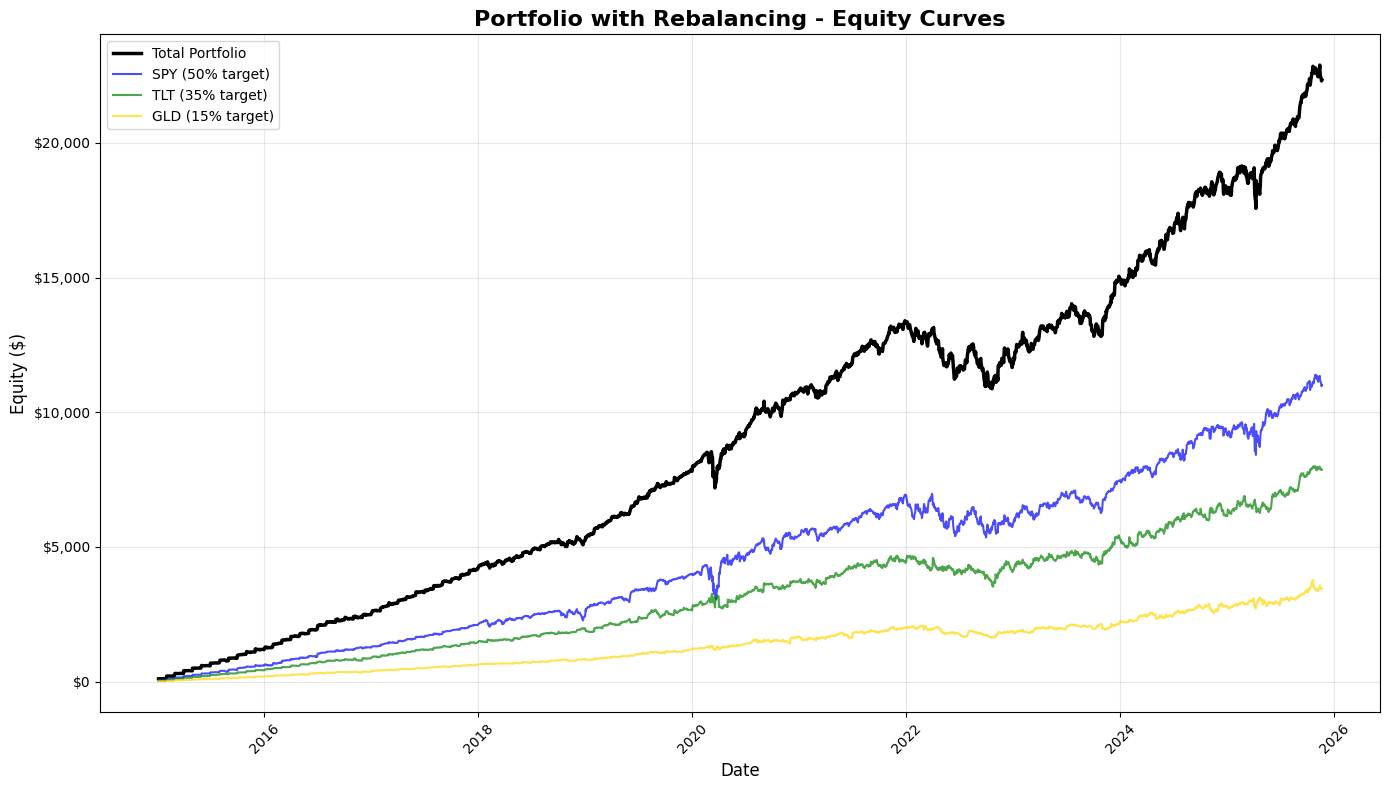

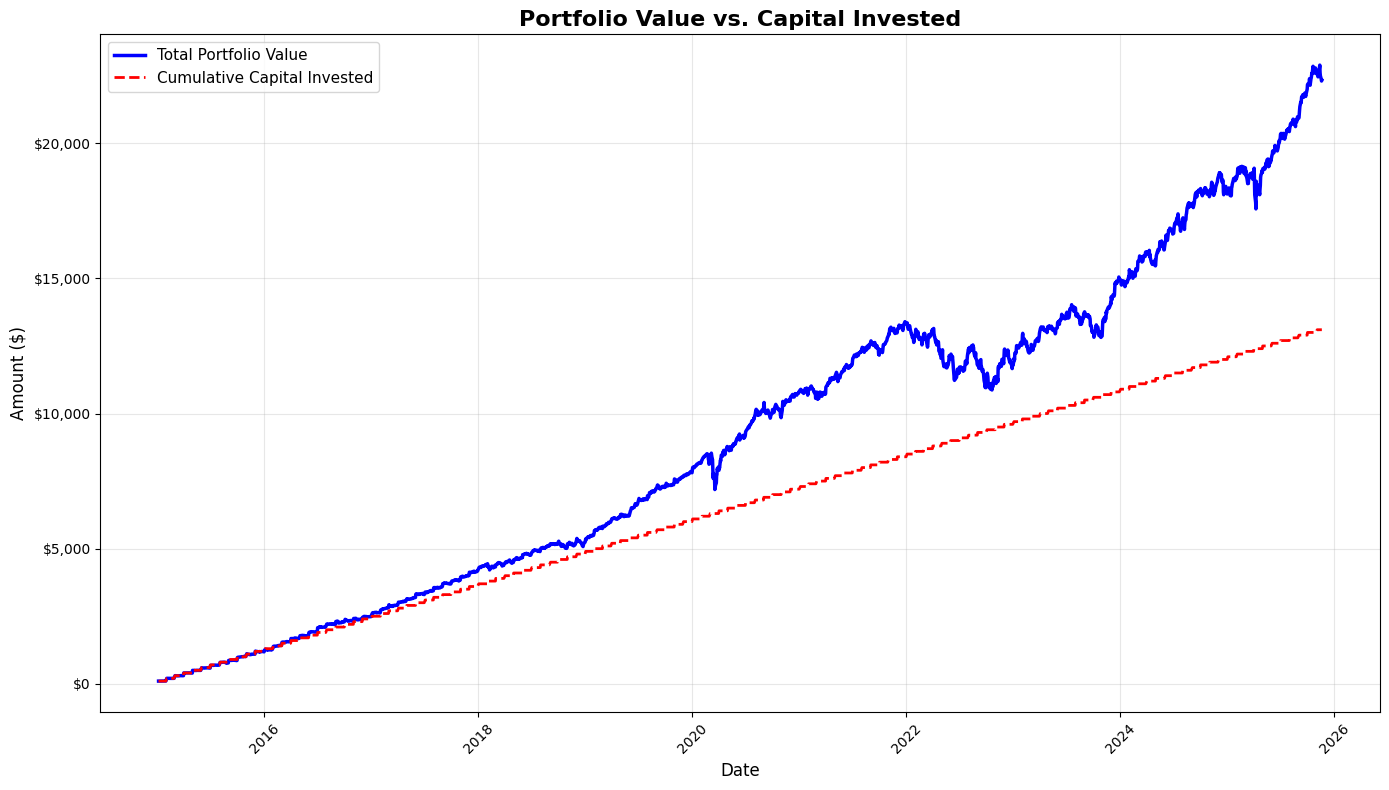

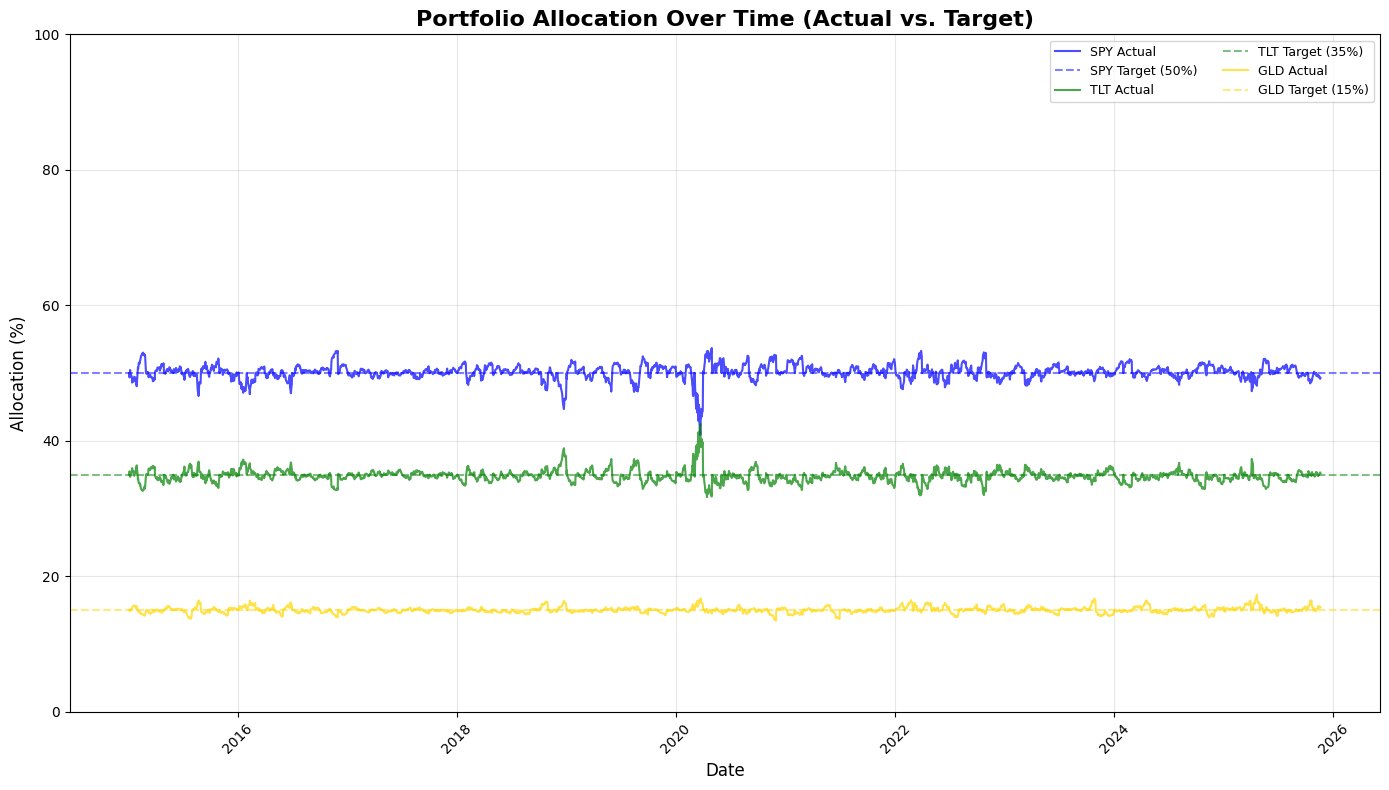

In [10]:
# 8. Static Visualizations

# 1. Plot all equity curves on a single chart
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(equity_df.index, equity_df['total_equity'], label='Total Portfolio', linewidth=2.5, color='black')
ax.plot(equity_df.index, equity_df['SPY_equity'], label='SPY (50% target)', linewidth=1.5, alpha=0.7, color='blue')
ax.plot(equity_df.index, equity_df['TLT_equity'], label='TLT (35% target)', linewidth=1.5, alpha=0.7, color='green')
ax.plot(equity_df.index, equity_df['GLD_equity'], label='GLD (15% target)', linewidth=1.5, alpha=0.7, color='gold')

ax.set_title('Portfolio with Rebalancing - Equity Curves', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity ($)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Plot cumulative capital invested alongside portfolio value
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(equity_df.index, equity_df['total_equity'], label='Total Portfolio Value', linewidth=2.5, color='blue')
ax.plot(equity_df.index, equity_df['capital_invested'], label='Cumulative Capital Invested', linewidth=2, color='red', linestyle='--')

ax.set_title('Portfolio Value vs. Capital Invested', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Amount ($)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Plot actual portfolio weights over time vs. target weights
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(weights_df.index, weights_df['SPY_weight'] * 100, label='SPY Actual', linewidth=1.5, color='blue', alpha=0.7)
ax.axhline(y=allocation_ratios['SPY'] * 100, color='blue', linestyle='--', linewidth=1.5, label='SPY Target (50%)', alpha=0.5)

ax.plot(weights_df.index, weights_df['TLT_weight'] * 100, label='TLT Actual', linewidth=1.5, color='green', alpha=0.7)
ax.axhline(y=allocation_ratios['TLT'] * 100, color='green', linestyle='--', linewidth=1.5, label='TLT Target (35%)', alpha=0.5)

ax.plot(weights_df.index, weights_df['GLD_weight'] * 100, label='GLD Actual', linewidth=1.5, color='gold', alpha=0.7)
ax.axhline(y=allocation_ratios['GLD'] * 100, color='gold', linestyle='--', linewidth=1.5, label='GLD Target (15%)', alpha=0.5)

ax.set_title('Portfolio Allocation Over Time (Actual vs. Target)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Allocation (%)', fontsize=12)
ax.legend(loc='best', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

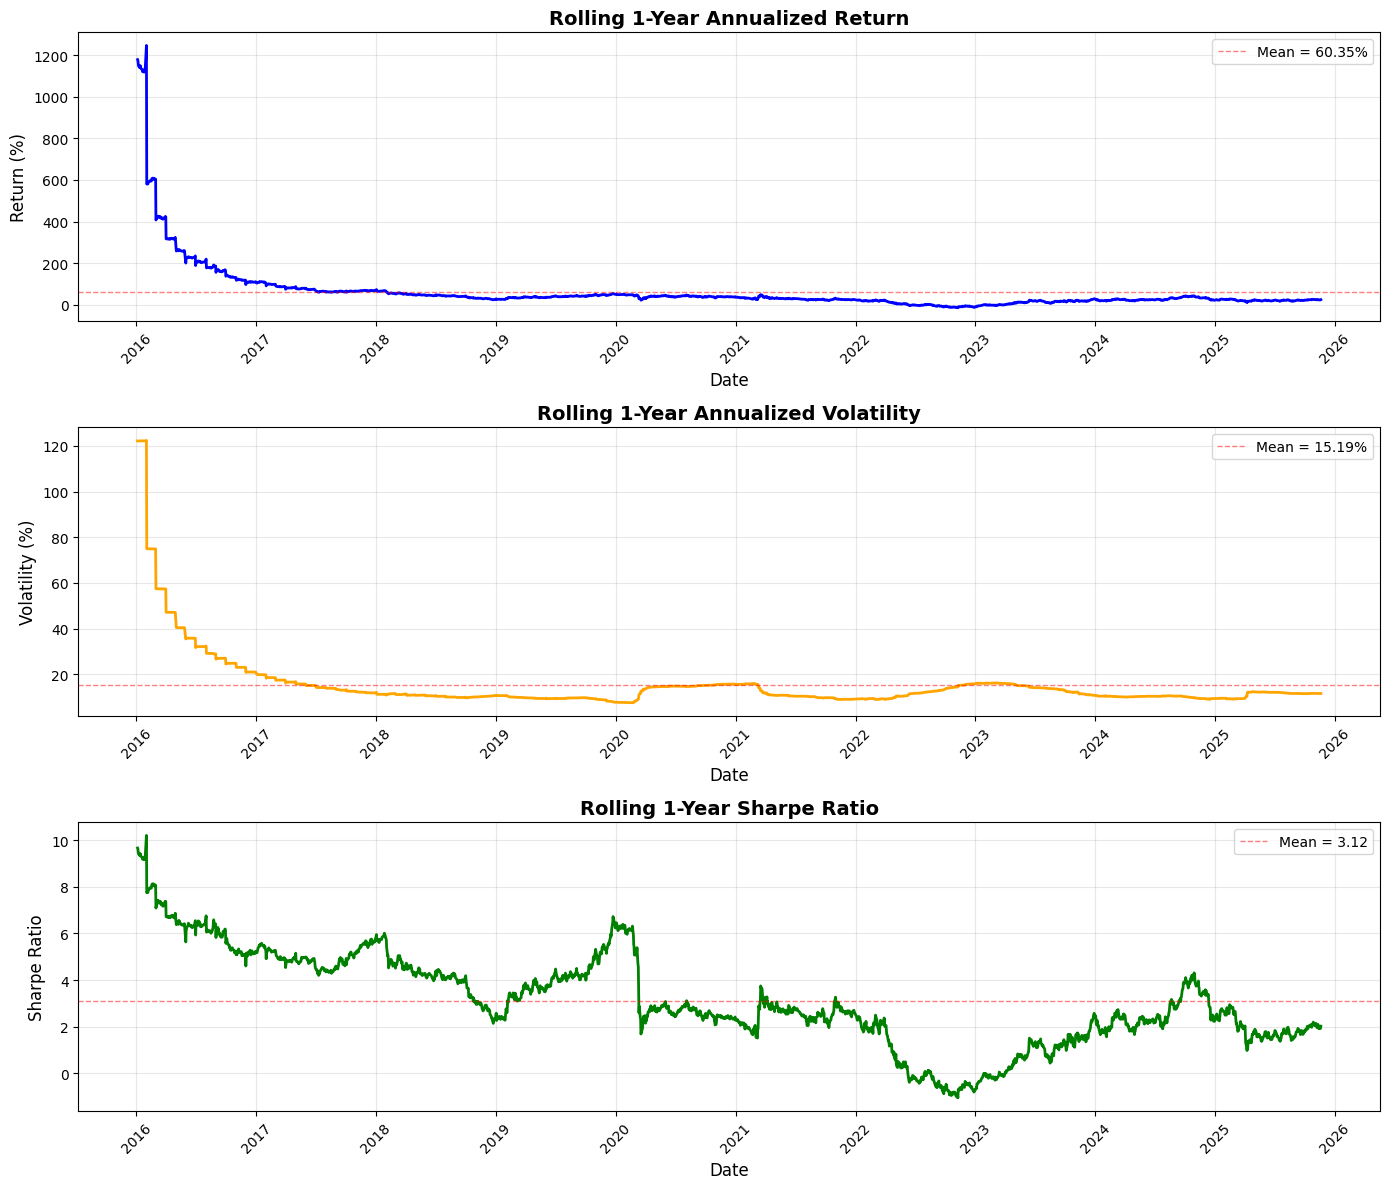


ROLLING METRICS SUMMARY (1-YEAR WINDOW)

Rolling Annualized Return:
  Mean: 60.35%
  Min:  -15.25%
  Max:  1247.45%

Rolling Annualized Volatility:
  Mean: 15.19%
  Min:  7.61%
  Max:  122.35%

Rolling Sharpe Ratio:
  Mean: 3.1207
  Min:  -1.0483
  Max:  10.1961


In [11]:
# 9. Rolling Performance Analysis

# Define rolling window (252 trading days = 1 year)
window = 252

# Calculate rolling metrics
rolling_return = returns_df['portfolio_return'].rolling(window=window).apply(
    lambda x: (1 + x).prod() ** (252 / len(x)) - 1
)

rolling_volatility = returns_df['portfolio_return'].rolling(window=window).std() * np.sqrt(252)

rolling_sharpe = rolling_return / rolling_volatility

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Rolling 1-Year Annualized Return
axes[0].plot(rolling_return.index, rolling_return * 100, linewidth=2, color='blue')
axes[0].axhline(y=rolling_return.mean() * 100, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Mean = {rolling_return.mean()*100:.2f}%')
axes[0].set_title('Rolling 1-Year Annualized Return', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Return (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best', fontsize=10)
axes[0].set_xlabel('Date', fontsize=12)

# 2. Rolling 1-Year Annualized Volatility
axes[1].plot(rolling_volatility.index, rolling_volatility * 100, linewidth=2, color='orange')
axes[1].axhline(y=rolling_volatility.mean() * 100, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Mean = {rolling_volatility.mean()*100:.2f}%')
axes[1].set_title('Rolling 1-Year Annualized Volatility', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best', fontsize=10)
axes[1].set_xlabel('Date', fontsize=12)

# 3. Rolling 1-Year Sharpe Ratio
axes[2].plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='green')
axes[2].axhline(y=rolling_sharpe.mean(), color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Mean = {rolling_sharpe.mean():.2f}')
axes[2].set_title('Rolling 1-Year Sharpe Ratio', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Sharpe Ratio', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='best', fontsize=10)
axes[2].set_xlabel('Date', fontsize=12)

# Format x-axis for all subplots
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics for rolling metrics
print("\n" + "=" * 50)
print("ROLLING METRICS SUMMARY (1-YEAR WINDOW)")
print("=" * 50)
print("\nRolling Annualized Return:")
print(f"  Mean: {rolling_return.mean():.2%}")
print(f"  Min:  {rolling_return.min():.2%}")
print(f"  Max:  {rolling_return.max():.2%}")

print("\nRolling Annualized Volatility:")
print(f"  Mean: {rolling_volatility.mean():.2%}")
print(f"  Min:  {rolling_volatility.min():.2%}")
print(f"  Max:  {rolling_volatility.max():.2%}")

print("\nRolling Sharpe Ratio:")
print(f"  Mean: {rolling_sharpe.mean():.4f}")
print(f"  Min:  {rolling_sharpe.min():.4f}")
print(f"  Max:  {rolling_sharpe.max():.4f}")
print("=" * 50)